# Dependencies

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from tqdm import tqdm
from collections import defaultdict

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data

## Cleaning and Merging

In [10]:
# OLD
df1 = pd.read_csv("../files/data/Corner_Crack_BH/SUBSET-SINGLE.csv", index_col=False)
# df1 = df1.drop(columns=["b/t"])
print(df1)

# Get unique combinations of the first four columns
CC_combinations = df1.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations))

           W/R   a/c   a/t   r/t  b/t      phi     K-T     K-B      K-P
0          2.2   0.1  0.10  1.25  1.0  0.00006  0.8162  0.9663   0.7523
1          2.2   0.1  0.10  1.25  1.0  0.00012  0.8409  0.9954   0.7750
2          2.2   0.1  0.10  1.25  1.0  0.00018  0.8549  1.0120   0.7880
3          2.2   0.1  0.10  1.25  1.0  0.00024  0.8646  1.0240   0.7970
4          2.2   0.1  0.10  1.25  1.0  0.00030  0.8720  1.0320   0.8037
...        ...   ...   ...   ...  ...      ...     ...     ...      ...
5515345  100.0  10.0  0.95  1.00  1.0  1.57056  1.9370 -1.1080  48.6900
5515346  100.0  10.0  0.95  1.00  1.0  1.57062  1.9150 -1.0960  48.1300
5515347  100.0  10.0  0.95  1.00  1.0  1.57068  1.8820 -1.0770  47.3100
5515348  100.0  10.0  0.95  1.00  1.0  1.57074  1.8360 -1.0510  46.1500
5515349  100.0  10.0  0.95  1.00  1.0  1.57080  1.7720 -1.0140  44.5500

[5515350 rows x 9 columns]
24524


In [11]:
# NEW
df2 = pd.read_csv("../files/data/Corner_Crack_BH/CASE24_KI_Single_Cracks.csv", index_col=False)
df2 = df2[df2['a/t'] < 1]
# df2 = df2.drop(columns=["b/t"])
print(df2)

# Get unique combinations of the first four columns
CC_combinations_ = df2.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations_))

             W/R   a/c   a/t   r/t  b/t      phi     K-T    K-B     K-P
0        200.000   0.1  0.10  0.50  1.0  0.00006  0.9527  0.979   4.655
1        200.000   0.1  0.10  0.50  1.0  0.00012  0.9788  1.006   4.782
2        200.000   0.1  0.10  0.50  1.0  0.00018  0.9972  1.025   4.873
3        200.000   0.1  0.10  0.50  1.0  0.00024  1.0100  1.038   4.934
4        200.000   0.1  0.10  0.50  1.0  0.00030  1.0180  1.046   4.974
...          ...   ...   ...   ...  ...      ...     ...    ...     ...
4306854  133.333  10.0  0.95  0.75  1.0  1.57056  2.2050 -1.321  73.200
4306855  133.333  10.0  0.95  0.75  1.0  1.57062  2.1800 -1.306  72.370
4306856  133.333  10.0  0.95  0.75  1.0  1.57068  2.1430 -1.284  71.140
4306857  133.333  10.0  0.95  0.75  1.0  1.57074  2.0900 -1.252  69.390
4306858  133.333  10.0  0.95  0.75  1.0  1.57080  2.0170 -1.209  66.980

[2162578 rows x 9 columns]
5000


In [12]:
# Common combinations
# Convert rows to tuples
A_tuples = set(map(tuple, CC_combinations_))
B_tuples = set(map(tuple, CC_combinations))

# Rows in CC_combinations_ that are in CC_combinations
A_in_B = np.array([row for row in CC_combinations_ if tuple(row) in B_tuples])

# Rows in CC_combinations_ that are NOT in CC_combinations
A_not_in_B = np.array([row for row in CC_combinations_ if tuple(row) not in B_tuples])

print("Rows in CC_combinations_ and in CC_combinations:", A_in_B.shape)
print("Rows in CC_combinations_ and NOT in CC_combinations:", A_not_in_B.shape)

Rows in CC_combinations_ and in CC_combinations: (743, 5)
Rows in CC_combinations_ and NOT in CC_combinations: (4257, 5)


In [13]:
# Remove rows from NEW df2
print("\nSpecific 2D array of 5-column combinations to remove:")
# Convert to DataFrame temporarily for cleaner printing
print(pd.DataFrame(A_in_B, columns=[f'col{i+1}' for i in range(5)]))


# --- Logic to remove rows ---

# Ensure the DataFrame has at least 5 columns
if df2.shape[1] < 5:
    raise ValueError("DataFrame must have at least 5 columns.")

# Ensure the 2D array has exactly 5 columns
if A_in_B.shape[1] != 5:
    raise ValueError("The A_in_B must have exactly 5 columns.")


# Get the column names for the first 5 columns from the DataFrame
key_cols = df2.columns[:5].tolist()

# 1. Convert the 2D numpy array to a DataFrame
#    Assign the key_cols names to match the DataFrame columns.
values_to_remove_df = pd.DataFrame(A_in_B, columns=key_cols)

# 2. Merge the original DataFrame with the values_to_remove_df
#    We want to identify rows in 'df2' that have a match in 'values_to_remove_df'.
#    A left merge with indicator will mark rows from 'df2' that match ('both').
merged_check = df2.merge(values_to_remove_df, on=key_cols, how='left', indicator=True)

# 3. Create a boolean mask for rows to KEEP
#    Keep rows where the '_merge' indicator is 'left_only' (meaning they were only in 'df2').
mask_rows_to_keep = merged_check['_merge'] == 'left_only'

# 4. Filter the merged_check DataFrame using the 'keep' mask
#    Drop the temporary '_merge' column and create a copy.
df_filtered = merged_check[mask_rows_to_keep].drop(columns='_merge').copy()

print("\nDataFrame after removing rows matching any of the combinations in the 2D array:")
print(df_filtered)



Specific 2D array of 5-column combinations to remove:
      col1  col2  col3  col4  col5
0    200.0   0.1  0.10  0.50   1.0
1    200.0   0.1  0.20  0.50   1.0
2    200.0   0.1  0.30  0.50   1.0
3    200.0   0.1  0.40  0.50   1.0
4    200.0   0.1  0.50  0.50   1.0
..     ...   ...   ...   ...   ...
738   80.0  10.0  0.60  1.25   1.0
739   80.0  10.0  0.70  1.25   1.0
740   80.0  10.0  0.80  1.25   1.0
741   80.0  10.0  0.90  1.25   1.0
742   80.0  10.0  0.95  1.25   1.0

[743 rows x 5 columns]

DataFrame after removing rows matching any of the combinations in the 2D array:
             W/R   a/c   a/t   r/t  b/t      phi     K-T     K-B     K-P
91174     20.000   0.1  0.10  5.00  1.0  0.00006  0.5941  0.4397   2.864
91175     20.000   0.1  0.10  5.00  1.0  0.00012  0.6104  0.4517   2.942
91176     20.000   0.1  0.10  5.00  1.0  0.00018  0.6219  0.4602   2.997
91177     20.000   0.1  0.10  5.00  1.0  0.00024  0.6297  0.4660   3.035
91178     20.000   0.1  0.10  5.00  1.0  0.00030  0.634

In [14]:
# Concatenate
df = pd.concat([df1, df_filtered], axis=0, ignore_index=True)
df

,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,2.200,0.1,0.10,1.25,1.0,0.00006,0.8162,0.9663,0.7523
1,2.200,0.1,0.10,1.25,1.0,0.00012,0.8409,0.9954,0.7750
2,2.200,0.1,0.10,1.25,1.0,0.00018,0.8549,1.0120,0.7880
3,2.200,0.1,0.10,1.25,1.0,0.00024,0.8646,1.0240,0.7970
4,2.200,0.1,0.10,1.25,1.0,0.00030,0.8720,1.0320,0.8037
...,...,...,...,...,...,...,...,...,...
7318625,133.333,10.0,0.95,0.75,1.0,1.57056,2.2050,-1.3210,73.2000
7318626,133.333,10.0,0.95,0.75,1.0,1.57062,2.1800,-1.3060,72.3700
7318627,133.333,10.0,0.95,0.75,1.0,1.57068,2.1430,-1.2840,71.1400
7318628,133.333,10.0,0.95,0.75,1.0,1.57074,2.0900,-1.2520,69.3900


## Merged df

In [15]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations))

28781


In [16]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [   1.6      1.8      2.       2.2      2.4      2.8      3.2      3.6
    4.       4.6      5.2      5.8      6.4      7.       8.      10.
   12.      12.5     15.      20.      25.      33.333   40.      50.
   57.143   66.7     75.019   80.     100.     125.     133.333  149.9
  175.     175.009  200.     300.3    500.     700.28   800.     900.901
 1000.   ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [ 0.1     0.111   0.125   0.1428  0.2     0.333   0.5     0.5714  0.667
  0.75    0.8     1.      1.25    1.333   1.5     1.75    2.      2.5
  3.      4.      5.      8.     10.    ]
Different b/t values:  [1.]


In [22]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:5])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

In [ ]:
d_final = np.zeros((len(CC_combinations)*128, 10))

for i, combination in tqdm(enumerate(CC_combinations)):
    data = np.zeros((128, 10))
    comb_tuple = tuple(combination)
    data[:,0] = i
    data[:,1:6] = comb_tuple

    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, -4]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    CC_phi_regular_128 = np.linspace(phi_min, phi_max, 132)
    data[:,-4] = CC_phi_regular_128[2:-2]

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,-4]
    assert len(phi_vals) > 16, len(phi_vals)
    phi_idxes = np.argsort(phi_vals)
    monotonic_phi_idxes = [phi_idxes[0]]
    prev_phi = phi_vals[phi_idxes[0]]
    for index in phi_idxes[1:]:
        now_phi = phi_vals[index]
        if now_phi > prev_phi:
            monotonic_phi_idxes.append(index)
            prev_phi = phi_vals[index]

    # Tension
    K_vals = d[filtered_indices][:,-3]
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
    data[:,-3] = interp_func(CC_phi_regular_128)[2:-2]

    # Bending
    K_vals = d[filtered_indices][:,-2]
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
    data[:,-2] = interp_func(CC_phi_regular_128)[2:-2]

    # Bearing
    K_vals = d[filtered_indices][:,-1]
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
    data[:,-1] = interp_func(CC_phi_regular_128)[2:-2]

    if np.isnan(data).any():
        print("WARNING: NaN at crack: ", i)

    else:
        d_final[i*128:i*128+128] = data

output_df = pd.DataFrame(d_final, columns=["c_index", "W/R", "a/c", "a/t", "r/t", "b/t", "phi", "K-T", "K-B", "K-P"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/CORNER_CRACK_BH_QUARTER_ELLIPSE.csv", index=False)

28781it [00:21, 1350.24it/s]


# Data Viz

In [ ]:
df = pd.read_csv("../files/data/FINAL_CSV/CORNER_CRACK_BH_QUARTER_ELLIPSE.csv")
df

,c_index,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,0.0,2.200,0.1,0.10,1.25,1.0,0.057972,0.931029,1.096668,0.858805
1,0.0,2.200,0.1,0.10,1.25,1.0,0.069428,0.947679,1.114230,0.874324
2,0.0,2.200,0.1,0.10,1.25,1.0,0.080884,0.967757,1.135983,0.892977
3,0.0,2.200,0.1,0.10,1.25,1.0,0.092340,0.990546,1.160526,0.913913
4,0.0,2.200,0.1,0.10,1.25,1.0,0.103796,1.014772,1.187478,0.936605
...,...,...,...,...,...,...,...,...,...,...
3683963,28780.0,133.333,10.0,0.95,0.75,1.0,1.467062,2.522433,-1.497326,83.527692
3683964,28780.0,133.333,10.0,0.95,0.75,1.0,1.478518,2.469612,-1.468863,81.792988
3683965,28780.0,133.333,10.0,0.95,0.75,1.0,1.489974,2.421220,-1.442476,80.196547
3683966,28780.0,133.333,10.0,0.95,0.75,1.0,1.501431,2.377552,-1.418226,78.782289


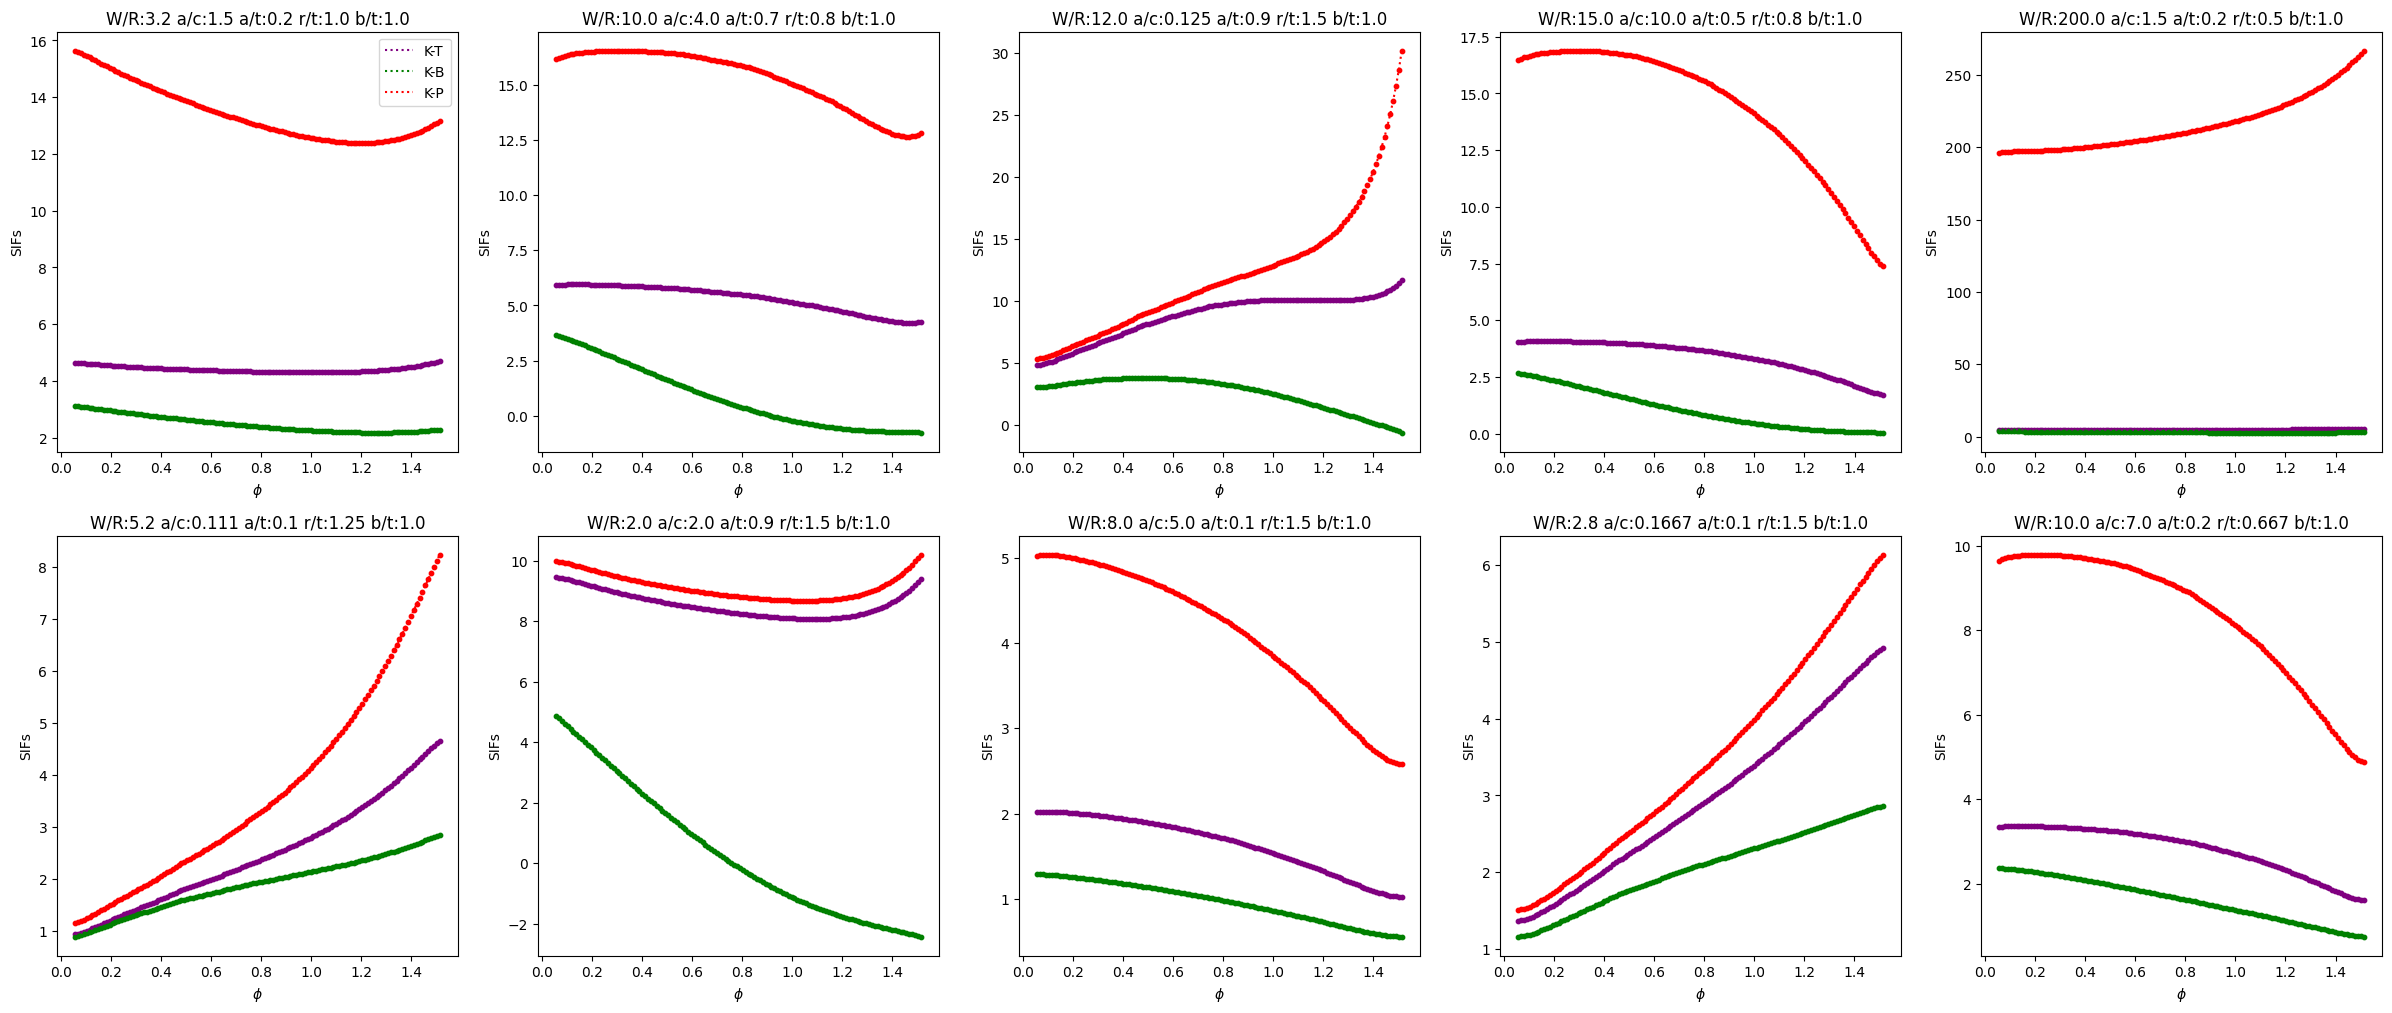

In [32]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

np.random.seed(100)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a_c = np.unique(data[:,2])
        a_t = np.unique(data[:,3])
        r_t = np.unique(data[:,4])
        b_t = np.unique(data[:,5])

        assert len(W_R) == 1
        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-4], data[:,-3], color='purple', s=10)
        axs[i,j].plot(data[:,-4], data[:,-3], label="K-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-2], color='green', s=10)
        axs[i,j].plot(data[:,-4], data[:,-2], label="K-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-1], color='red', s=10)
        axs[i,j].plot(data[:,-4], data[:,-1], label="K-P", color='red', linestyle=":")

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{} b/t:{}".format(W_R[0], a_c[0], a_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()